# RNN Models for Determining LKML Authors

We posit that it would be interesting to be able to learn people's style of writing, such that they could be identified by their writing style. This has a variety of applications in 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os
import sys
from pprint import pprint
from IPython.display import SVG

from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, GRU
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD, Adagrad, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.metrics import f1_score, confusion_matrix

Using TensorFlow backend.


In [2]:
file_dir = os.path.join(os.pardir, 'data', 'archive.csv')

lkml_df = pd.read_csv(file_dir)

In [3]:
lkml_df.head()

,Unnamed: 0,Author,Time,Topic,Msg,Size
0,1,Jarkko Sakkinen,"Thu, 26 Oct 2017 21:07:28 +0200",Re: Fixing CVE-2017-15361,"On Thu, Oct 26, 2017 at 03:51:27PM +0000, Alex...",2541
1,2,Stefano Stabellini,"Thu, 26 Oct 2017 12:11:40 -0700",[PATCH v7 01/13] xen/pvcalls: introduce the pv...,Introduce a xenbus frontend for the pvcalls pr...,148
2,3,Stefano Stabellini,"Thu, 26 Oct 2017 12:11:38 -0700 (PDT)",[PATCH v7 00/13] introduce the Xen PV Calls fr...,"Hi all,\nthis series introduces the frontend f...",1944
3,4,Stefano Stabellini,"Thu, 26 Oct 2017 12:11:42 -0700",[PATCH v7 03/13] xen/pvcalls: connect to the b...,Implement the probe function for the pvcalls f...,325
4,5,James Morris,"Thu, 26 Oct 2017 21:06:29 +0200 (CEST)",Re: regression in 4.14-rc2 caused by apparmor:...,"On Thu, 26 Oct 2017, Linus Torvalds wrote:\n> ...",1036


In [4]:
lkml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127627 entries, 0 to 127626
Data columns (total 6 columns):
Unnamed: 0    127627 non-null int64
Author        127627 non-null object
Time          127627 non-null object
Topic         127627 non-null object
Msg           127627 non-null object
Size          127627 non-null int64
dtypes: int64(2), object(4)
memory usage: 5.8+ MB


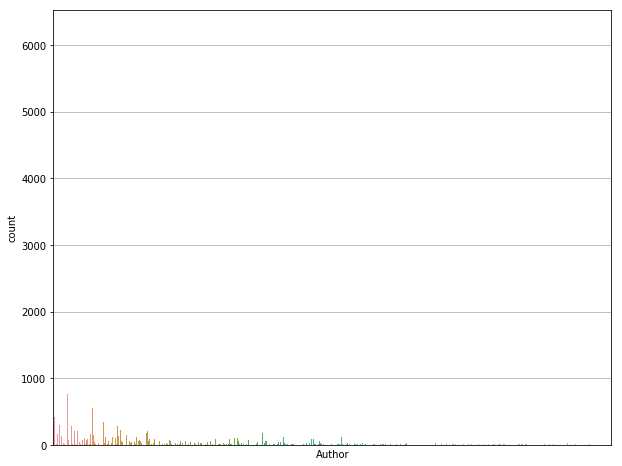

In [5]:
sns.countplot(data=lkml_df, x='Author')
plt.xticks([])
plt.show()

We'll go ahead and select for only authors who have a significant contribution to the mailing list. Not only does this make performance easier to evaluate, but it will also make it much easier to learn each author, supposing such a thing is even possible.

In [6]:
high_contrib = np.unique(lkml_df.Author)[np.unique(lkml_df.Author, return_counts=True)[1] >= 150]
contrib_lkml = lkml_df.loc[lkml_df.Author.isin(high_contrib)]
contrib_lkml.shape

(78158, 6)

Good, now we only have authors who have contributed at least 150 entries to the LKML, and we still have more nearly two-thirds of the dataset left over.

In [7]:
import re

rand_idx = np.random.choice(contrib_lkml.index)
print(contrib_lkml.Msg[rand_idx])
print('==========================================================')
print(contrib_lkml.Author[rand_idx])
print('==========================================================')

On Mon, Sep 25, 2017 at 05:31:05PM +0000, Mario.Limonciello@dell.com wrote:
> > -----Original Message-----
> > From: Andy Shevchenko [mailto:andy.shevchenko@gmail.com]
> > Sent: Monday, September 25, 2017 1:04 PM
> > To: Pali Rohár <pali.rohar@gmail.com>
> > Cc: Limonciello, Mario <Mario_Limonciello@Dell.com>; dvhart@infradead.org;
> > LKML <linux-kernel@vger.kernel.org>; Platform Driver <platform-driver-
> > x86@vger.kernel.org>; quasisec@google.com
> > Subject: Re: [PATCH 06/12] platform/x86: dell-wmi-smbios: Add a sysfs interface
> > for SMBIOS tokens
> > 
> > On Mon, Sep 25, 2017 at 7:23 PM, Pali Rohár <pali.rohar@gmail.com> wrote:
> > > On Thursday 21 September 2017 08:57:11 Mario Limonciello wrote:
> > >> Currently userspace tools can access system tokens via the dcdbas
> > >> kernel module and a SMI call that will cause the platform to execute
> > >> SMM code.
> > >>
> > >> With a goal in mind of deprecating the dcdbas kernel module a different
> > >> method for accessing these 

If we look through here enough, we'll find that a lot of times, the author of a specific message will be kind enough to sign it, giving away completely the answer. As this this is not what we set out to do and is severely uninteresting, we will try to remove any mentions of the author's name in their message.

In [8]:
import re

def remove_name(row):
    result = row['Msg']
    for word in row['Author'].split():
        if len(word) > 2:
            check_word = re.sub(r'[\",\(\)\.\\]', '', word)
            result = re.sub(check_word, '', result)
    return result
    
contrib_lkml['Text'] = contrib_lkml.apply(lambda row : remove_name(row), axis=1)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
import re

rand_idx = np.random.choice(contrib_lkml.index)
print(contrib_lkml.Text[rand_idx])
print('==========================================================')
print(contrib_lkml.Author[rand_idx])
print('==========================================================')

On Tue, Aug 01, 2017 at 06:43:14AM -0700, Andy Lutomirski wrote:
> Anyway, can you document whatever property you require with a comment
> in switch_mm() or wherever you're finding that property so that future
> arch changes don't break it?
We need _a_ smp_mb after rq->curr store. x86 has plenty.
> > +static void membarrier_private_expedited(void)
> > +{
> > +       int cpu;
> > +       bool fallback = false;
> > +       cpumask_var_t tmpmask;
> > +
> > +       if (num_online_cpus() == 1)
> > +               return;
> > +
> > +       /*
> > +        * Matches memory barriers around rq->curr modification in
> > +        * scheduler.
> > +        */
> > +       smp_mb();       /* system call entry is not a mb. */
> > +
> > +       /*
> > +        * Expedited membarrier commands guarantee that they won't
> > +        * block, hence the GFP_NOWAIT allocation flag and fallback
> > +        * implementation.
> > +        */
> > +       if (!zalloc_cpumask_var(&tmpmask, GFP_NOWAIT)) {
> > +  

That's much better. If we wanted to go another step further, we could remove the full last few lines, essentially anytime we detected a signature, so as to void personal flourishes giving someone away, but it may actually be interesting to learn those.

We will now import GloVe, in order to embed the words we are interested in to make them useable as inputs to our RNN.

## Glorified Screwing Around (Data Exploration)

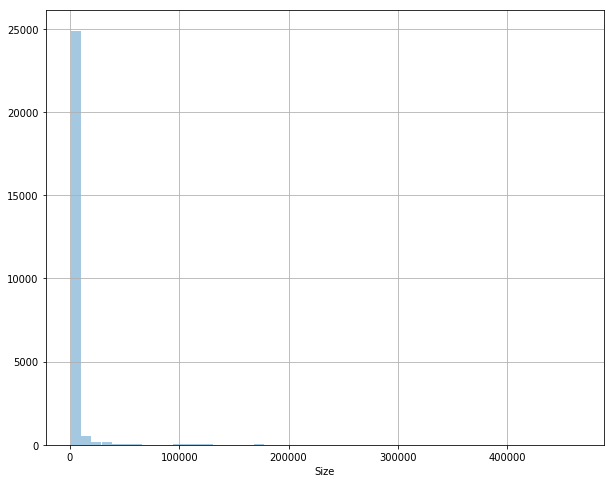

In [10]:
sns.distplot(contrib_lkml[contrib_lkml.Size > 1000].Size, norm_hist=False, kde=False)
plt.show()

1000 words looks like it gets the full sequence in the majority of our data anyways, so we can use that as our max length.

In [11]:
max_length = 1000

In [12]:
n_classes = np.unique(contrib_lkml.Author).shape[0]
n_classes

191

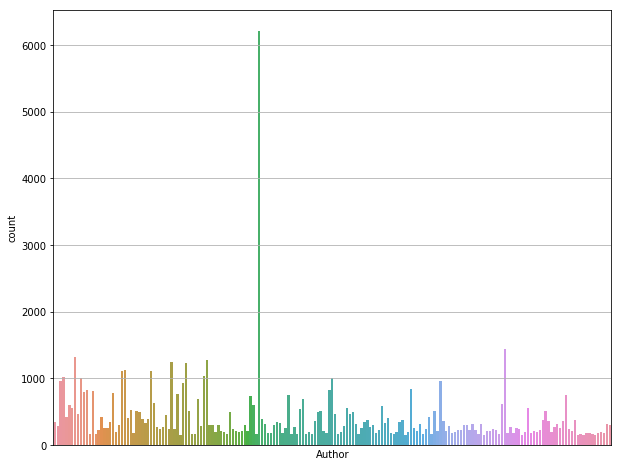

In [13]:
sns.countplot(contrib_lkml.Author)
plt.xticks([])
plt.show()

Oh, my...

In [14]:
contrib_lkml.Author.value_counts().argmax()

'Greg Kroah-Hartman'

[For the interested](https://en.wikipedia.org/wiki/Greg_Kroah-Hartman)

But also because we're the curious type, let's see about everyone's favorite Linus Torvalds.

In [15]:
np.array([contrib_lkml.Author == 'Linus Torvalds']).sum()

489

Not bad for the man the kernel was named for.

### Done Screwing Around, Back to the $\text{Real Data Science}^{\text{TM}}$

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(contrib_lkml.Text.values)
sequences = tokenizer.texts_to_sequences(contrib_lkml.Text.values)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 238800 unique tokens. Distilled to 238800 top words.


In [17]:
# we have a lot of unique words, so a larger embedding is necessary
glove_file = os.path.join(os.pardir, 'data', 'glove.6B.200d.txt') 

# code for setting up GloVe embedding copied from:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

embeddings_index = {}
f = open(glove_file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_size = 200

embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embed_layer = Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

authors = LabelBinarizer().fit_transform(contrib_lkml.Author)

X_train, X_test, y_train, y_test = train_test_split(sequences, authors)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## Evaluation Criteria

### Metrics

### Cross-Validation

## Finding Models that Work

In [19]:
# this code can be found in my previous projects at https://github.com/carterkoehler

def predict_categ(model, data):
    return(np.argmax(model.predict(data), axis=1))

def evaluate_confusion(model, test_data, test_target, normalize=True, print_f1=True):
    target_int = np.argmax(test_target, axis=1)
    yhat = predict_categ(model, test_data)
    conf = confusion_matrix(target_int, yhat[:,np.newaxis])

    if normalize:
        conf = conf / np.unique(target_int, return_counts=True)[1][:, np.newaxis]
    if print_f1:
        print('F1 score of this model is {}'.format(f1_score(target_int, yhat, average='micro')))
        
    sns.heatmap(conf, annot=False)
    plt.show()
    
def plot_history(history):
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Cross-Entropy Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()

In [26]:
rnn_generic = Sequential()

rnn_generic.add(embed_layer)
rnn_generic.add(LSTM(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_generic.add(Dense(200, activation='relu'))
rnn_generic.add(Dropout(0.2))
rnn_generic.add(Dense(n_classes, activation='softmax'))

rnn_generic.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_generic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 191)               38391     
Total params: 48,159,591
Trainable params: 399,391
Non-trainable params: 47,760,200
_________________________________________________________________


In [27]:
history_generic = rnn_generic.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=3)

Train on 58618 samples, validate on 19540 samples
Epoch 1/3
58618/58618 [==============================] - 159s 3ms/step - loss: 4.6649 - acc: 0.1208 - val_loss: 4.2570 - val_acc: 0.1757
Epoch 2/3
58618/58618 [==============================] - 157s 3ms/step - loss: 4.1196 - acc: 0.2020 - val_loss: 3.7603 - val_acc: 0.2496
Epoch 3/3
58618/58618 [==============================] - 157s 3ms/step - loss: 3.7399 - acc: 0.2532 - val_loss: 3.4932 - val_acc: 0.2815


We're doing alright, but it looks like we can keep training. Let's go overboard.

In [28]:
history_generic = rnn_generic.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 156s 3ms/step - loss: 3.4908 - acc: 0.2854 - val_loss: 3.2399 - val_acc: 0.3202
Epoch 2/10
58618/58618 [==============================] - 158s 3ms/step - loss: 3.2559 - acc: 0.3171 - val_loss: 2.9956 - val_acc: 0.3558
Epoch 3/10
58618/58618 [==============================] - 157s 3ms/step - loss: 3.0085 - acc: 0.3572 - val_loss: 2.7228 - val_acc: 0.4106
Epoch 4/10
58618/58618 [==============================] - 157s 3ms/step - loss: 2.7355 - acc: 0.4064 - val_loss: 2.4627 - val_acc: 0.4566
Epoch 5/10
58618/58618 [==============================] - 156s 3ms/step - loss: 2.5069 - acc: 0.4412 - val_loss: 2.2538 - val_acc: 0.4878
Epoch 6/10
58618/58618 [==============================] - 156s 3ms/step - loss: 2.3014 - acc: 0.4780 - val_loss: 2.0502 - val_acc: 0.5244
Epoch 7/10
58618/58618 [==============================] - 157s 3ms/step - loss: 2.1088 - acc: 0.5125 - val_loss: 1.8920 - 

Holy shit, we're still improving! Let's keep going.

In [29]:
history_generic = rnn_generic.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 157s 3ms/step - loss: 1.5344 - acc: 0.6245 - val_loss: 1.3689 - val_acc: 0.6635
Epoch 2/10
58618/58618 [==============================] - 157s 3ms/step - loss: 1.4425 - acc: 0.6435 - val_loss: 1.2928 - val_acc: 0.6830
Epoch 3/10
58618/58618 [==============================] - 157s 3ms/step - loss: 1.3527 - acc: 0.6632 - val_loss: 1.2312 - val_acc: 0.6910
Epoch 4/10
58618/58618 [==============================] - 156s 3ms/step - loss: 1.2805 - acc: 0.6792 - val_loss: 1.1667 - val_acc: 0.7082
Epoch 5/10
58618/58618 [==============================] - 157s 3ms/step - loss: 1.2091 - acc: 0.6948 - val_loss: 1.1267 - val_acc: 0.7172
Epoch 6/10
58618/58618 [==============================] - 156s 3ms/step - loss: 1.1491 - acc: 0.7073 - val_loss: 1.0955 - val_acc: 0.7253
Epoch 7/10
58618/58618 [==============================] - 157s 3ms/step - loss: 1.1033 - acc: 0.7190 - val_loss: 1.0582 - 

F1 score of this model is 0.7567041965199591


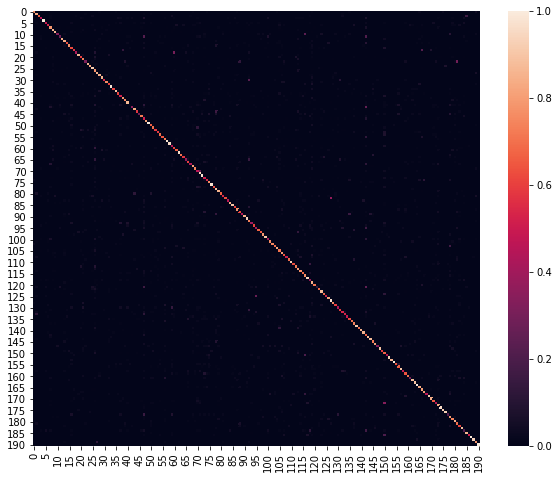

In [30]:
evaluate_confusion(rnn_generic, X_test, y_test)

Though a heatmap is perhaps not the most ideal way to visualize a confusion matrix of this dimension, the fact that it is so obviously nearly diagonal, with not too many common confusions indicates that this classifier is actually very good. Granted, it had to train for quite a while to get to this point, but we could easily repeat this process.

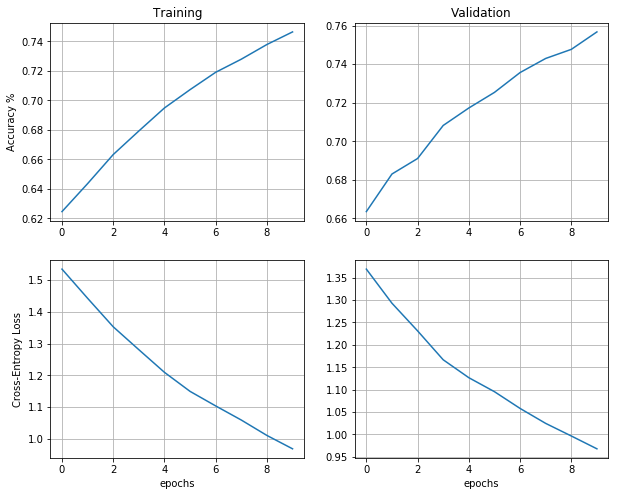

In [31]:
plot_history(history_generic)

Unfortunately, the history only captures the last few epochs, but we can see that the model was, in fact, still improving on both the training and validation sets.

Conclusion: RNNs are completely bonkers.

This next RNN will have the same general architecture as the previous one, but we'll adjust the size of the output layer.

In [20]:
rnn_lstm = Sequential()

rnn_lstm.add(embed_layer)
rnn_lstm.add(LSTM(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_lstm.add(Dense(300, activation='relu'))
rnn_lstm.add(Dropout(0.2))
rnn_lstm.add(Dense(n_classes, activation='softmax'))

rnn_lstm.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 191)               57491     
Total params: 48,198,791
Trainable params: 438,591
Non-trainable params: 47,760,200
_________________________________________________________________


In [21]:
history_lstm = rnn_lstm.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 167s 3ms/step - loss: 4.6071 - acc: 0.1301 - val_loss: 4.1708 - val_acc: 0.2002
Epoch 2/10
58618/58618 [==============================] - 158s 3ms/step - loss: 4.0549 - acc: 0.2093 - val_loss: 3.7133 - val_acc: 0.2547
Epoch 3/10
58618/58618 [==============================] - 159s 3ms/step - loss: 3.6767 - acc: 0.2612 - val_loss: 3.4027 - val_acc: 0.2987
Epoch 4/10
58618/58618 [==============================] - 158s 3ms/step - loss: 3.4168 - acc: 0.2948 - val_loss: 3.1640 - val_acc: 0.3318
Epoch 5/10
58618/58618 [==============================] - 158s 3ms/step - loss: 3.2040 - acc: 0.3259 - val_loss: 3.0074 - val_acc: 0.3588
Epoch 6/10
58618/58618 [==============================] - 158s 3ms/step - loss: 2.9908 - acc: 0.3591 - val_loss: 2.7830 - val_acc: 0.3951
Epoch 7/10
58618/58618 [==============================] - 157s 3ms/step - loss: 2.7886 - acc: 0.3887 - val_loss: 2.5655 - 

F1 score of this model is 0.5600818833162743


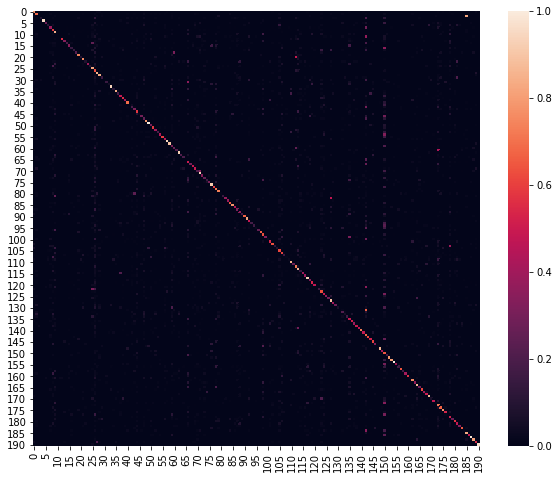

In [22]:
evaluate_confusion(rnn_lstm, X_test, y_test)

This model is currently performing worse, but we trained it for much less time than the previous LSTM. If we compare the accuracy scores on the tenth training epoch, we find that this one was at $55\%$, where the first model was at $52\%$. So, we might say that in preliminary testing, they're about equal.

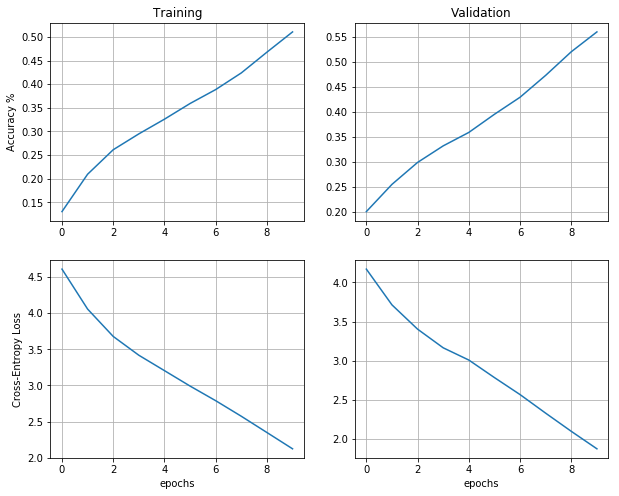

In [23]:
plot_history(history_lstm)

In [24]:
rnn_gru = Sequential()

rnn_gru.add(embed_layer)
rnn_gru.add(GRU(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_gru.add(Dense(300, activation='relu'))
rnn_gru.add(Dropout(0.2))
rnn_gru.add(Dense(n_classes, activation='softmax'))

rnn_gru.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               240600    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 191)               57491     
Total params: 48,118,591
Trainable params: 358,391
Non-trainable params: 47,760,200
_________________________________________________________________


In [25]:
history_gru = rnn_gru.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 107s 2ms/step - loss: 4.5078 - acc: 0.1551 - val_loss: 4.0941 - val_acc: 0.2092
Epoch 2/10
58618/58618 [==============================] - 106s 2ms/step - loss: 3.9919 - acc: 0.2210 - val_loss: 3.7632 - val_acc: 0.2513
Epoch 3/10
58618/58618 [==============================] - 105s 2ms/step - loss: 3.6388 - acc: 0.2602 - val_loss: 3.4182 - val_acc: 0.2902
Epoch 4/10
58618/58618 [==============================] - 105s 2ms/step - loss: 3.3942 - acc: 0.2920 - val_loss: 3.2031 - val_acc: 0.3297
Epoch 5/10
58618/58618 [==============================] - 106s 2ms/step - loss: 3.1838 - acc: 0.3288 - val_loss: 2.9688 - val_acc: 0.3711
Epoch 6/10
58618/58618 [==============================] - 105s 2ms/step - loss: 3.0191 - acc: 0.3572 - val_loss: 2.7930 - val_acc: 0.3964
Epoch 7/10
58618/58618 [==============================] - 106s 2ms/step - loss: 2.8010 - acc: 0.3923 - val_loss: 2.5900 - 

F1 score of this model is 0.5443705220061412


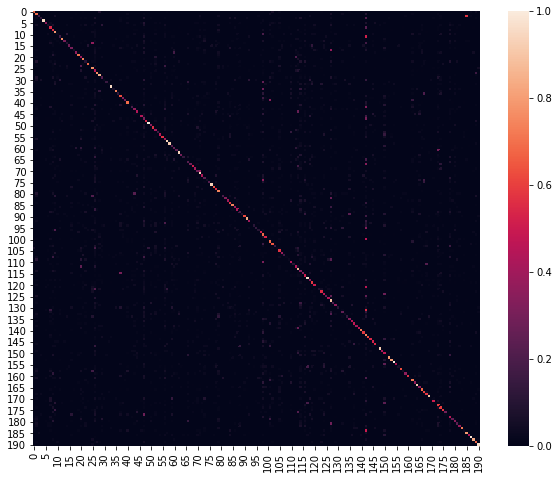

In [26]:
evaluate_confusion(rnn_gru, X_test, y_test)

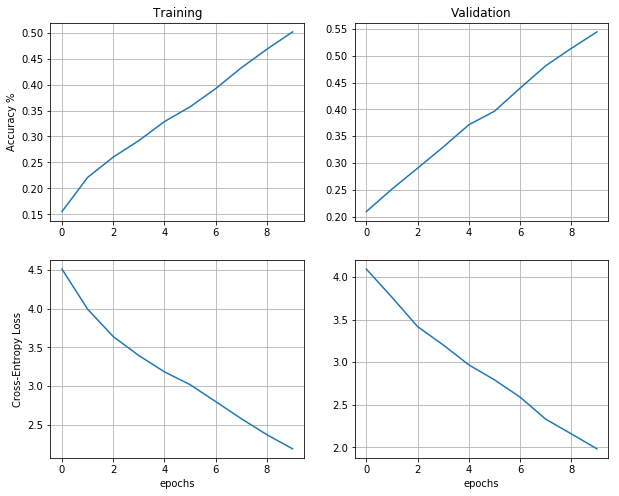

In [27]:
plot_history(history_gru)

Now, let's change some of the neuron counts and increase the dropout rate.

In [28]:
rnn_gru_tweak = Sequential()

rnn_gru_tweak.add(embed_layer)
rnn_gru_tweak.add(GRU(300, dropout=0.3, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_gru_tweak.add(Dense(300, activation='relu'))
rnn_gru_tweak.add(Dropout(0.2))
rnn_gru_tweak.add(Dense(n_classes, activation='softmax'))

rnn_gru_tweak.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_gru_tweak.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
gru_2 (GRU)                  (None, 300)               450900    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 191)               57491     
Total params: 48,358,891
Trainable params: 598,691
Non-trainable params: 47,760,200
_________________________________________________________________


In [29]:
history_gru_tweak = rnn_gru_tweak.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 155s 3ms/step - loss: 4.4758 - acc: 0.1595 - val_loss: 4.0262 - val_acc: 0.2149
Epoch 2/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.9423 - acc: 0.2268 - val_loss: 3.6033 - val_acc: 0.2624
Epoch 3/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.5600 - acc: 0.2730 - val_loss: 3.3515 - val_acc: 0.3017
Epoch 4/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.3125 - acc: 0.3099 - val_loss: 3.0780 - val_acc: 0.3526
Epoch 5/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.4115 - acc: 0.2973 - val_loss: 3.5063 - val_acc: 0.2884
Epoch 6/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.5137 - acc: 0.2749 - val_loss: 3.3641 - val_acc: 0.2982
Epoch 7/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.3205 - acc: 0.3008 - val_loss: 3.1402 - 

F1 score of this model is 0.44882292732855683


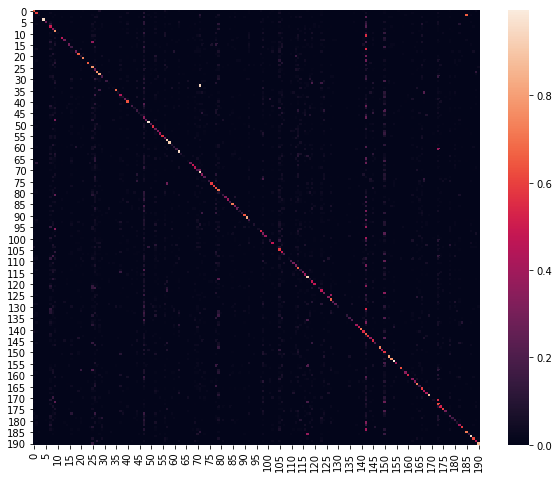

In [30]:
evaluate_confusion(rnn_gru_tweak, X_test, y_test)

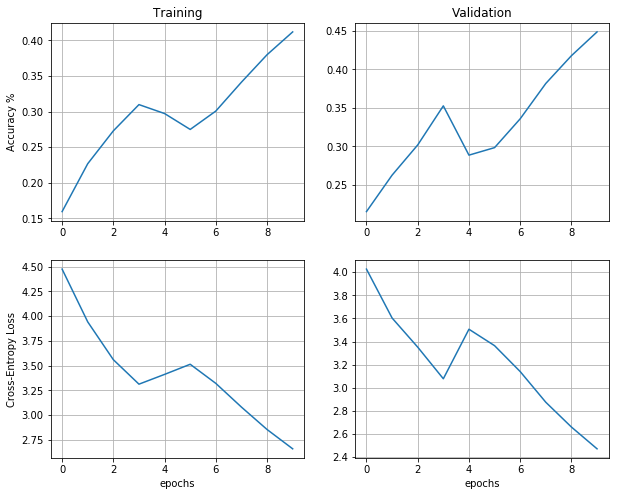

In [31]:
plot_history(history_gru_tweak)